## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd 'drive/MyDrive/HW3'

/content/drive/MyDrive/HW3


## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [7]:
import numpy as np
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):
    unique, counts = np.unique(sequence, return_counts=True)
    s = np.sum(counts)
    return 1-np.sum(np.square(counts/s))


def entropy(sequence):
    unique, counts = np.unique(sequence, return_counts=True)
    s = np.sum(counts)
    return -np.sum(counts/s*np.log2(counts/s))

In [ ]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [ ]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [ ]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [87]:
import pandas as pd
from sklearn.metrics import accuracy_score

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)
print(train_df['price_range'])
train_df.head()
#val_df.head()


(1200, 21)
(300, 21)
0       1
1       0
2       0
3       0
4       1
       ..
1195    1
1196    0
1197    0
1198    1
1199    0
Name: price_range, Length: 1200, dtype: int64


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


In [136]:
#x_train, y_train = train_df[:], train_df['price_range'].values
#valx_test, valy_test = val_df[:], val_df['price_range'].values
#print(x_train, y_train)
cols = []
for col in train_df:
    cols.append(col)
def pdframe2np(x_train):
    y_train = x_train['price_range'].values
    #print(y_train)
    x_train_np = np.array([y_train], dtype=float)
    #print(x_train_np)
    for i, col in enumerate(cols):
        r = x_train[col]
        npr = r.to_numpy()
        x_train_np = np.append(x_train_np, [npr], axis=0)
        
    #print(x_train_np[0])
    x_train_np = np.delete(x_train_np, 0, axis=0) # remove tmp row
    x_train_np = np.delete(x_train_np, -1, axis=0) # remove ans row
    return x_train_np, y_train
x_train, y_train = pdframe2np(train_df)
valx_test, valy_test = pdframe2np(val_df)
print(x_train.shape)


(20, 1200)


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [91]:
def ada_gini(sequence):
    ans = sequence.T[0]
    weight = sequence.T[1]
    w0_sum = np.sum(weight[ans==0])
    w1_sum = np.sum(weight[ans==1])
    #print(w0_sum, w1_sum)
    w_sum = np.sum(weight)
    return 1 - (w0_sum / w_sum) ** 2 - (w1_sum / w_sum) ** 2

In [104]:
class Node():
    def __init__(self, depth):
        self.Lchild = None
        self.Rchild = None
        self.attr = None
        self.depth = depth
        self.data = None
        self.thre = None
        self.classify = -1 # if is leaf, should be either 0 or 1
        # for adaboost
        self.Dt_data = None
    
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, Treetype=0):
        self.criterion = criterion
        self.max_depth = max_depth
        self.current = None
        self.root = None
        self.Treetype = Treetype # 0 for basic decision tree, 1 for adaboost, 2 for random forest
        

    def make_tree(self):
        #print("len:", len(self.current.Dt_data))
        if self.is_stop():
            #create leaf label
            is0 = 0
            is1 = 0
            for ans in self.current.data[-1]:
                if ans == 0:
                    is0 += 1
                else:
                    is1 += 1
            if is0 > is1:
                self.current.classify = 0
            else:
                self.current.classify = 1
            return
        
        best_feat = self.split_attr()
        self.current.Lchild = Node(depth = self.current.depth+1)
        self.current.Rchild = Node(depth = self.current.depth+1)
        
        tmp = self.current.data[:,-1]
        tmpLdata = np.zeros_like([tmp], dtype=float)
        tmpRdata = np.zeros_like([tmp], dtype=float)
        if self.Treetype == 0:
            for i in range(len(self.current.data[0])): # for every row of data
                row = self.current.data[:,i]
                if row[best_feat] <= self.current.thre:
                    tmpLdata = np.append(tmpLdata, [row], axis=0)
                else:
                    tmpRdata = np.append(tmpRdata, [row], axis=0)
        elif self.Treetype == 1:
            DtL = []
            DtR = []
            for i in range(len(self.current.data[0])): # for every row of data
                row = self.current.data[:,i]
                if row[best_feat] <= self.current.thre:
                    tmpLdata = np.append(tmpLdata, [row], axis=0)
                    DtL.append(self.current.Dt_data[i])
                else:
                    tmpRdata = np.append(tmpRdata, [row], axis=0)
                    DtR.append(self.current.Dt_data[i])
            self.current.Lchild.Dt_data = np.array(DtL)
            self.current.Rchild.Dt_data = np.array(DtR)
        tmpLdata = np.delete(tmpLdata, 0, axis=0) #remove the last tmp row
        tmpRdata = np.delete(tmpRdata, 0, axis=0)
        self.current.Lchild.data = tmpLdata.T # transpose from row=datas to row=attributes
        self.current.Rchild.data = tmpRdata.T
        parent = self.current
        self.current = parent.Lchild
        self.make_tree()
        self.current = parent.Rchild
        self.make_tree()
        return

    def is_stop(self):
        if self.current.depth>=self.max_depth or len( np.unique(self.current.data[-1]) ) == 1: # meet max depth or node is pure
            return True
        
    def split_attr(self):
        min_crit = 100000000
        best_feat = 0
        thre_hold = None
        for attr in range(len(self.current.data)-1):
            #discrete and continous
            
            for u in self.current.data[attr]: # u is the threadshold
                left = []
                right = []
                if self.Treetype == 0:
                    for datas, ans in zip(self.current.data[attr], self.current.data[-1]):
                        if datas <= u: #left
                            left.append(ans)
                        else: #right
                            right.append(ans)
                elif self.Treetype == 1:
                    for i, (datas, ans) in enumerate(zip(self.current.data[attr], self.current.data[-1])):
                        if datas <= u: #left
                            left.append([ans,self.current.Dt_data[i]])
                        else: #right
                            right.append([ans,self.current.Dt_data[i]])
                # calculate the sum of (left entropy and right entropy)
                crit = self.cal_crit(np.array(left)) * (len(left) / len(self.current.data[attr])) + self.cal_crit(np.array(right)) * (len(right) / len(self.current.data[attr]))
                
                if crit < min_crit: # update best feature and threadshold
                    min_crit = crit
                    best_feat = attr
                    thre_hold = u

        self.current.attr = best_feat
        self.current.thre = thre_hold
        return best_feat

    def cal_crit(self, ans):
        if self.Treetype == 1:
            if len(ans) == 0:
                return 0
            return ada_gini(ans)
        if self.criterion == 'gini':
            return gini(ans)
        elif self.criterion == 'entropy':
            return entropy(ans)

    def fit(self, x_data, y_data, return_count=0, Dt=None):
        x_data = np.append(x_data, [y_data], axis=0)
        self.root = Node(0)
        self.root.data = x_data
        
        self.root.Dt_data = Dt # for adaboost
        self.current = self.root
        #print(self.current.data[-1])
        self.make_tree()
        if return_count == 1:
            return self.feat_count(self.root)
    def predict(self, x_data):
        y_pred = []
        for i in range(len(x_data[0])): # for every row of data
            row = x_data[:,i]
            self.current = self.root
            while self.current.classify == -1:
                attr = self.current.attr
                if row[attr] <= self.current.thre: # lowew than threadshold -> left
                    self.current = self.current.Lchild
                else:
                    self.current = self.current.Rchild

            y_pred.append(self.current.classify)
        return np.array(y_pred)
    def feat_count(self, current):
        count = np.zeros(21)
        if current.attr is None:
          return count
        count[current.attr] += 1
        if current.classify != -1: # is leaf
            return count
        else:
            count += self.feat_count(current.Lchild)
            #print(self.feat_count(current.Lchild))
            count += self.feat_count(current.Rchild)
            #print(self.feat_count(current.Rchild))
        return count


    


### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [ ]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train, y_train)
y_pred1 = clf_depth3.predict(valx_test)
acc1 = accuracy_score(valy_test, y_pred1)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train, y_train)
y_pred2 = clf_depth10.predict(valx_test)
acc2 = accuracy_score(valy_test, y_pred2)

print(acc1, acc2)

0.9166666666666666 0.9366666666666666


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [ ]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train, y_train)
y_pred1 = clf_gini.predict(valx_test)
acc1 = accuracy_score(valy_test, y_pred1)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train, y_train)
y_pred2 = clf_entropy.predict(valx_test)
acc2 = accuracy_score(valy_test, y_pred2)
print(acc1, acc2)

0.9166666666666666 0.93


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [ ]:
DT = DecisionTree(criterion='gini', max_depth=10)
count = DT.fit(x_train, y_train, return_count=1)
print(count)

[19.  0.  0.  0.  2.  0.  0.  2.  1.  0.  0.  9.  5.  9.  0.  0.  0.  0.
  0.  0.  0.]


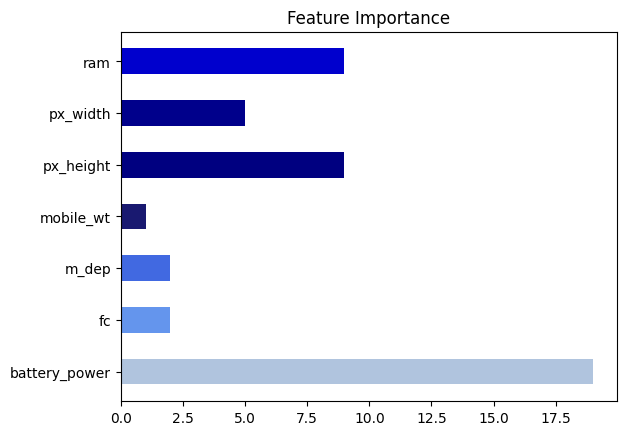

In [ ]:
import matplotlib.pyplot as plt
x = []
y = []
for i, c in enumerate(count):
    if c != 0:
        x.append(cols[i])
        y.append(c)
plt.barh(x, y, height=0.5, align='center', color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'] )
plt.title("Feature Importance")
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [128]:
y = [1,-1,-1]
x = [1,1,0]
y = np.array(y)
x = np.array(x)
x+=y
print(x)

[ 2  0 -1]


In [133]:
import math
from tqdm import trange
class AdaBoost():
    def __init__(self, n_estimators):
        self.n = n_estimators
        self.weaks = []
        self.alphas = []

    def fit(self, x_data, y_data):
        #print(y_data)
        Dt = np.ones(len(y_data))
        Dt = Dt / len(y_data) #initialize the weight of every data to 1/m
        y_ans = np.copy(y_data)
        y_ans[y_data==0] = -1
        #print(y_data)
        for t in trange(self.n):
            #print(Dt)
            alpha = 0
            weak_clf = DecisionTree(criterion='gini', max_depth=1, Treetype=1)
            weak_clf.fit(x_data, y_data, Dt=Dt)
            y_pred = weak_clf.predict(x_data)
            
            y_pred[y_pred==0] = -1
            epsilon = np.sum(Dt[y_pred != y_ans]) # weight error
            print(epsilon)
            if epsilon == 0:
              alpha = 100 # set alpha large because this weak learner classifies perfectly
            else:
              alpha = (1/2) * np.log( (1 - epsilon) / epsilon ) # exponential loss
            Dt = Dt * np.exp(- alpha * y_ans * y_pred) # update weight function
            Dt = Dt / Dt.sum() # normalization

            self.weaks.append(weak_clf)
            self.alphas.append(alpha)

    def predict(self, x_data):
        final_pred = np.zeros(x_data.shape[1])
        #print(final_pred)
        for clf, a in zip(self.weaks, self.alphas):
            y_pred = clf.predict(x_data)
            y_pred[y_pred==0] = -1
            final_pred += (y_pred * a)
            #print("ypred: ",final_pred)
            #print("A: ", a)
            #print(clf.root.Dt_data)
        final_pred[final_pred>0] = 1
        final_pred[final_pred<=0] = 0
        return final_pred

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [135]:
clf_ada10 = AdaBoost(n_estimators=10)
#print(y_train)
clf_ada10.fit(x_train, y_train)
y_pred1 = clf_ada10.predict(valx_test)
acc1 = accuracy_score(valy_test, y_pred1)
print(acc1)

 10%|█         | 1/10 [00:41<06:12, 41.34s/it]

0.08


 20%|██        | 2/10 [01:17<05:06, 38.29s/it]

0.2785326086956522


 30%|███       | 3/10 [01:54<04:23, 37.59s/it]

0.2834274952919021


 40%|████      | 4/10 [02:29<03:40, 36.81s/it]

0.34888304862023656


 50%|█████     | 5/10 [03:06<03:03, 36.79s/it]

0.3839556004036327


 60%|██████    | 6/10 [03:41<02:24, 36.11s/it]

0.20860577891207502


 70%|███████   | 7/10 [04:18<01:49, 36.34s/it]

0.4087451250773063


 80%|████████  | 8/10 [04:55<01:13, 36.56s/it]

0.3749034321480774


 90%|█████████ | 9/10 [05:30<00:36, 36.15s/it]

0.3999382061224526


100%|██████████| 10/10 [06:08<00:00, 36.86s/it]

0.5
0.8933333333333333


In [138]:
clf_ada10 = AdaBoost(n_estimators=20)
#print(y_train)
clf_ada10.fit(x_train, y_train)
y_pred1 = clf_ada10.predict(valx_test)
acc1 = accuracy_score(valy_test, y_pred1)
print(acc1)

  5%|▌         | 1/20 [00:42<13:25, 42.37s/it]

0.08


 10%|█         | 2/20 [01:23<12:26, 41.50s/it]

0.2785326086956522


 15%|█▌        | 3/20 [02:06<12:02, 42.49s/it]

0.2834274952919021


 20%|██        | 4/20 [02:45<10:53, 40.85s/it]

0.34888304862023656


 25%|██▌       | 5/20 [03:33<10:53, 43.53s/it]

0.3839556004036327


 30%|███       | 6/20 [04:10<09:38, 41.35s/it]

0.20860577891207502


 35%|███▌      | 7/20 [04:53<09:02, 41.71s/it]

0.4087451250773063


 40%|████      | 8/20 [05:31<08:06, 40.57s/it]

0.3749034321480774


 45%|████▌     | 9/20 [06:15<07:38, 41.70s/it]

0.3999382061224526


 50%|█████     | 10/20 [06:53<06:45, 40.57s/it]

0.5


 55%|█████▌    | 11/20 [07:47<06:41, 44.65s/it]

0.5


 60%|██████    | 12/20 [08:32<05:57, 44.73s/it]

0.5


 65%|██████▌   | 13/20 [09:14<05:07, 43.89s/it]

0.5


 70%|███████   | 14/20 [09:52<04:13, 42.29s/it]

0.5


 75%|███████▌  | 15/20 [10:31<03:25, 41.05s/it]

0.5


 80%|████████  | 16/20 [11:07<02:39, 39.77s/it]

0.5


 85%|████████▌ | 17/20 [11:46<01:58, 39.37s/it]

0.5


 90%|█████████ | 18/20 [12:34<01:24, 42.08s/it]

0.5


 95%|█████████▌| 19/20 [13:22<00:43, 43.78s/it]

0.5


100%|██████████| 20/20 [14:10<00:00, 42.50s/it]

0.5
0.8933333333333333


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [ ]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n = n_estimators
        self.max_feat = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.weak = []
    def fit(self, x_data, y_data):
        for i in range(self.n):
          select_ind = np.random.choice(len(y_data), len(y_data), replace=self.boostrap)
          clf = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, Treetype=2)
          clf.fit(x_data[select_ind], y_data[select_ind])
          self.weak.append(clf)

    def predict(self, x_data):
        pass

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [ ]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [ ]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [ ]:
def train_your_model(data):
    ## Define your model and training 
    return

In [ ]:
my_model = train_your_model(train_df)

In [ ]:
y_pred = my_model.predict(x_test)

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [ ]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")
